In [ ]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath("../.."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.utils import save_model_weights_to_disk
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier, complex_mlp_classifier
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
x_train = np.load('../data/images/train_images_augmented.npy')[:,:,:,:]
y_train = np.load('../data/labels/train_labels_augmented.npy')
x_test = np.load('../data/images/test_images.npy')[:,:,:,:]
y_test = np.load('../data/labels/test_labels.npy')

# Temporal study (model precision over time) 

In [ ]:
### we need to go in range for all time points of the input data, and for each we do 3 different seeds ###
seeds = [42, 43, 44]
all_confusion_matrices_cellfate = np.zeros((11, 2, 2))
def temporal_study(train_images_augmented, train_labels_augmented, test_images, test_labels, seed = 42):
    mean_diagonals = np.zeros((train_images_augmented.shape[1]))
    precisions = np.zeros((train_images_augmented.shape[1]))

    for i in range(train_images_augmented.shape[1]): # 11 cell normalised time points
        x_train = train_images_augmented[:,i,:,:]
        y_train = train_labels_augmented
        x_test = test_images[:,i,:,:]
        y_test = test_labels

        config_ae = {
            'batch_size': 30,
            'epochs': 15,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 5,
            'lambda_adv': 1,
        }

        config_cellfate = {
            'batch_size': 30,
            'epochs': 100,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 6,
            'lambda_adv': 4,
            'lambda_cov': 0.0001,
            'lambda_contra': 8,
        }

        config_clf = {
            'batch_size': 30,
            'epochs': 50,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
        }
        # do I need to restart the encoder and decoder??
        results_ae = train_autoencoder(config_ae, x_train)
        encoder = results_ae['encoder']
        decoder = results_ae['decoder']
        discriminator = results_ae['discriminator']

        ## TO CHECK if the break works
        results_cellfate = train_cellfate(config_cellfate, encoder, decoder, discriminator, x_train, y_train, x_test, y_test)
        encoder = results_cellfate['encoder']
        decoder = results_cellfate['decoder']

        tf.keras.utils.set_random_seed(config_clf['seed'])

        classifier = mlp_classifier(latent_dim=config_clf['latent_dim'])
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_clf['learning_rate']), metrics=['accuracy'])

        x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) 
        history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config_clf['batch_size'], epochs=config_clf['epochs'], validation_data=(x_val, y_val)) 

        y_pred = classifier.predict(x_test_)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums

        mean_diagonal = np.mean(np.diag(conf_matrix_normalized))
        precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])

        mean_diagonals[i] = mean_diagonal
        precisions[i] = precision
        all_confusion_matrices_cellfate[i] = conf_matrix_normalized

        save_model_weights_to_disk(encoder, decoder, discriminator, output_dir=f"model_weights_seed{seed}_tp{i}.h5")
        #np.save(f"mean_diagonals_{i}.npy", mean_diagonals)
        #np.save(f"precisions_{i}.npy", precisions)
        np.save(f"all_confusion_matrices_cellfate_seed44_{i}.npy", all_confusion_matrices_cellfate)

        print("time point:", i, "conf matrix:", conf_matrix_normalized, "precision:", precision, "mean diagonal:", mean_diagonal)
    
    return mean_diagonals, precisions, all_confusion_matrices_cellfate

In [ ]:
diagonals_seed42, precisions_seed42, conf_matrices_seed42 = temporal_study(train_images_augmented=x_train, train_labels_augmented=y_train, test_images=x_test, test_labels=y_test, seed = 42)
diagonals_seed43, precisions_seed43, conf_matrices_seed43 = temporal_study(train_images_augmented=x_train, train_labels_augmented=y_train, test_images=x_test, test_labels=y_test, seed = 43)
diagonals_seed44, precisions_seed44, conf_matrices_seed44 = temporal_study(train_images_augmented=x_train, train_labels_augmented=y_train, test_images=x_test, test_labels=y_test, seed = 44)

In [2]:
# load all confusion matrices (had to rerun the previous a few times because the kernel was crashing occasionally, so here I'm concatenating the saved results for all those runs)

conf_matrix_cellfate_seed42 = np.sum((np.load('/Users/inescunha/Documents/GitHub/CellFate/data/temporal_study/all_confusion_matrices_cellfate_6.npy'), np.load('/Users/inescunha/Documents/GitHub/CellFate/data/temporal_study/all_confusion_matrices_cellfate_10.npy')), axis=0)
conf_matrix_cellfate_seed43 = np.sum((np.load('/Users/inescunha/Documents/GitHub/CellFate/data/temporal_study/all_confusion_matrices_cellfate_seed43_3.npy'), np.load('/Users/inescunha/Documents/GitHub/CellFate/data/temporal_study/all_confusion_matrices_cellfate_seed43_6.npy'), np.load('/Users/inescunha/Documents/GitHub/CellFate/data/temporal_study/all_confusion_matrices_cellfate_seed43_10.npy')), axis=0)
conf_matrix_cellfate_seed44 = np.sum((np.load('/Users/inescunha/Documents/GitHub/CellFate/data/temporal_study/all_confusion_matrices_cellfate_seed44_4.npy'), np.load('/Users/inescunha/Documents/GitHub/CellFate/data/temporal_study/all_confusion_matrices_cellfate_seed44_10.npy')), axis=0)

conf_matrix_cellfate = np.stack((conf_matrix_cellfate_seed42, conf_matrix_cellfate_seed43, conf_matrix_cellfate_seed44), axis=0)

In [3]:
# calculate precisions

precision_cellfate = np.zeros((11, 3))
accuracy_cellfate = np.zeros((11, 3))
false_positives_cellfate = np.zeros((11, 3))   
false_negatives_cellfate = np.zeros((11, 3))

for tp in range(conf_matrix_cellfate.shape[1]):
    for seed in range(conf_matrix_cellfate.shape[0]):
        conf_matrix = conf_matrix_cellfate[seed, tp]
        precision_cellfate[tp, seed] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
        accuracy_cellfate[tp, seed] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
        false_positives_cellfate[tp, seed] = conf_matrix[1,0] #/ np.sum(conf_matrix[1,:])
        false_negatives_cellfate[tp, seed] = conf_matrix[0,1] #/ np.sum(conf_matrix[0,:])

In [4]:
mean_precisions = np.mean(precision_cellfate, axis=1)
std_precisions = np.std(precision_cellfate, axis=1)

mean_accuracies = np.mean(accuracy_cellfate, axis=1)
std_accuracies = np.std(accuracy_cellfate, axis=1)

mean_false_positives = np.mean(false_positives_cellfate, axis=1)
std_false_positives = np.std(false_positives_cellfate, axis=1)

mean_false_negatives = np.mean(false_negatives_cellfate, axis=1)
std_false_negatives = np.std(false_negatives_cellfate, axis=1)

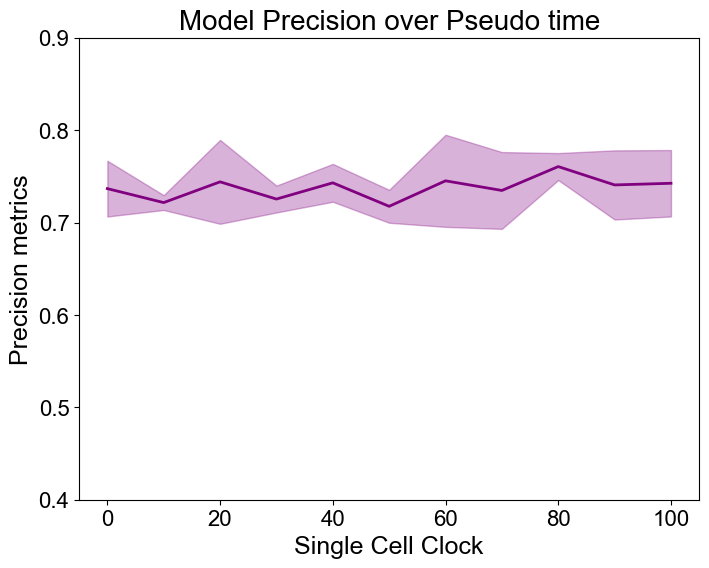

In [5]:
time_points = np.linspace(0, 100, len(mean_precisions))

# Plot
plt.figure(figsize=(8, 6))

# Precision
plt.plot(time_points, mean_precisions, color='purple', linewidth=2, label='Precision')
plt.fill_between(time_points, mean_precisions - std_precisions, mean_precisions + std_precisions,
                 color='purple', alpha=0.3)

# # Accuracy (purple)
# plt.plot(time_points, mean_accuracies, color='gray', linewidth=2, label='Accuracy')
# plt.fill_between(time_points, mean_accuracies - std_accuracies, 
#                  mean_accuracies + std_accuracies, color='gray', alpha=0.3)

# # False Positives (green)
# plt.plot(time_points, mean_false_positives, color='green', linewidth=2)
# plt.fill_between(time_points, mean_false_positives - std_false_positives,
#                  mean_false_positives + std_false_positives, color='green', alpha=0.3)

# # False Negatives (blue)
# plt.plot(time_points, mean_false_negatives, color='blue', linewidth=2)
# plt.fill_between(time_points, mean_false_negatives - std_false_negatives,
#                     mean_false_negatives + std_false_negatives, color='blue', alpha=0.3)

# Formatting
plt.xlabel("Single Cell Clock", fontsize=18, fontname="Arial")
plt.ylabel("Precision metrics", fontsize=18, fontname="Arial")
plt.title("Model Precision over Pseudo time", fontsize=20, fontname="Arial")
plt.xticks(fontsize=16, fontname="Arial")
plt.yticks(fontsize=16, fontname="Arial")
plt.ylim(0.4, 0.9)  # Set y-axis range
#plt.legend(fontsize=14)
#plt.grid(True, linestyle="--", alpha=0.6)

# Save the figure with high quality
#plt.savefig("temporal_study.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Figure 2A - Latent Spaces over Time

In [8]:
img_shape = (x_train.shape[1], x_train.shape[2], 1)

config = {
        'batch_size': 30,
        'epochs': 100,
        'learning_rate': 0.001,
        'seed': 42,
        'latent_dim': 2,
        'GaussianNoise_std': 0.003,
        'lambda_recon': 6,
        'lambda_adv': 4,
        'lambda_cov': 0.0001,
        'lambda_contra': 8,
    }

## 10% of cell time

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


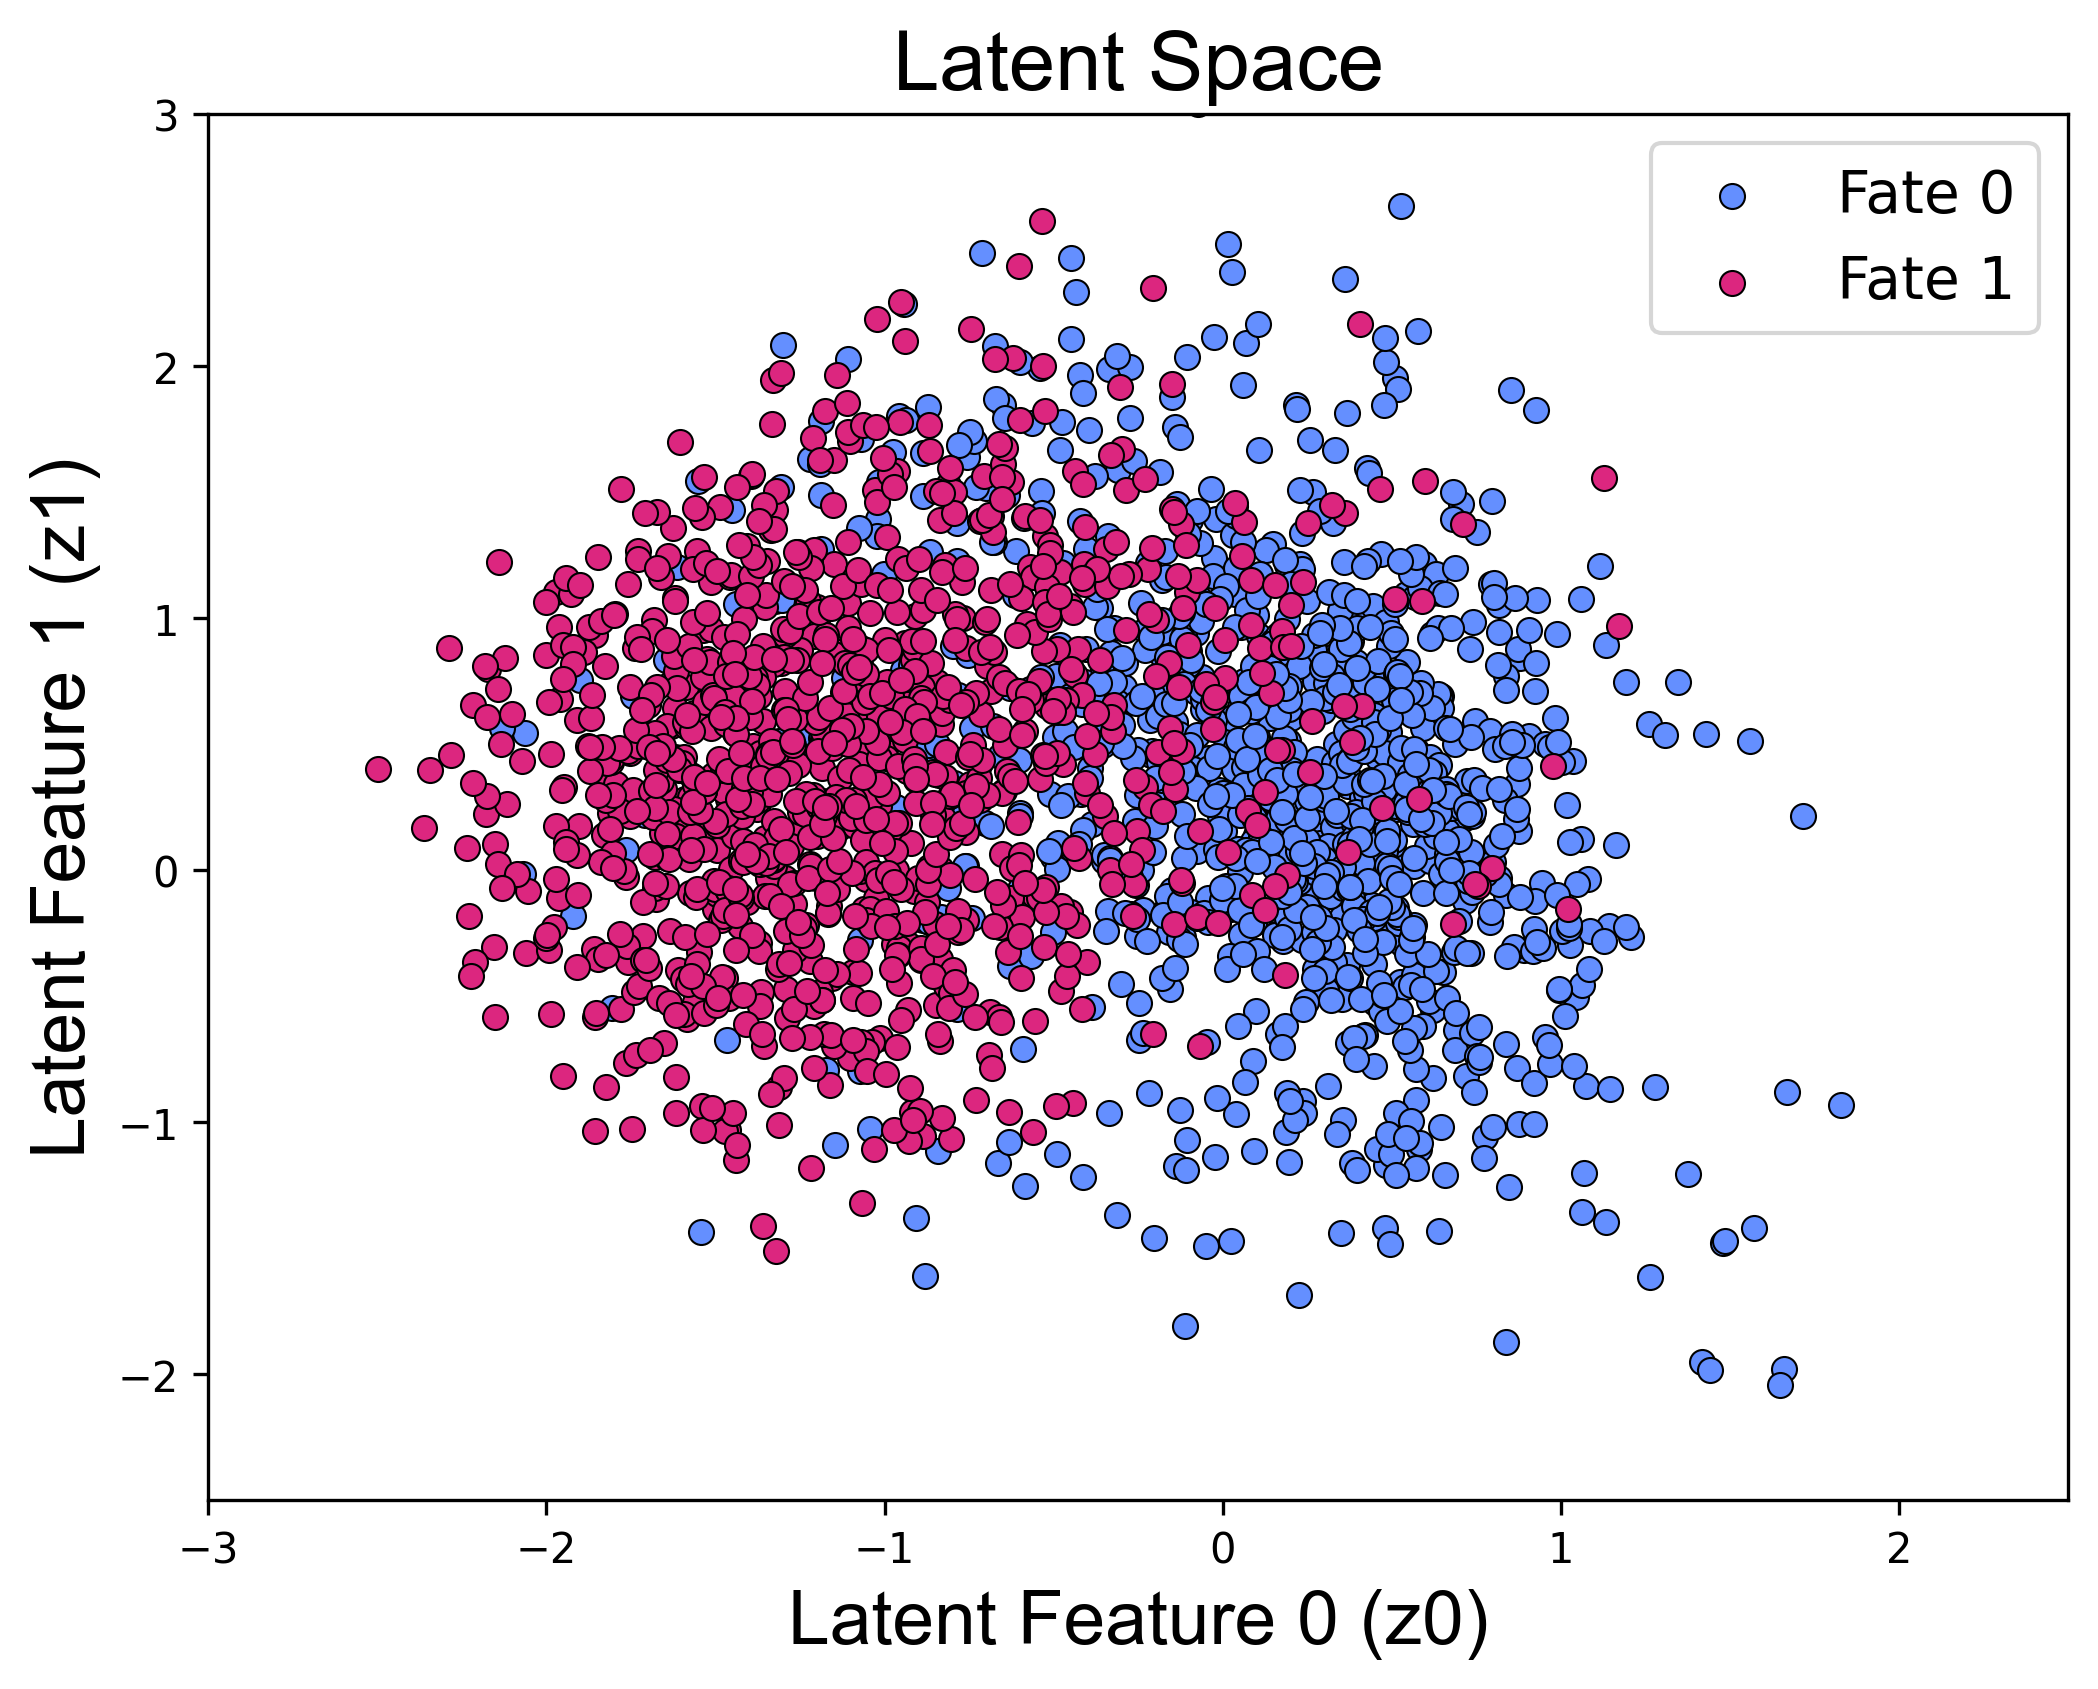

In [9]:
#### latent space correctly saved

x_train = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/images/train_images_augmented.npy')[:,1,:,:]
y_train = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/labels/train_labels_augmented.npy')
x_test = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/images/test_images.npy')[:,1,:,:]
y_test = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/labels/test_labels.npy')
img_shape = (x_train.shape[1], x_train.shape[2], 1)

encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
discriminator = Discriminator(latent_dim=config['latent_dim']).model

# NOTE: I changed the name of the files with the model weights (I had uploaded them to the google drive)
encoder.load_weights("/Users/inescunha/Downloads/encodertp1.weights.h5")
decoder.load_weights("/Users/inescunha/Downloads/decodertp1.weights.h5")

# Predict the latent representations
latent_2d = encoder.predict(x_train)  # Shape (1380, 2)

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately with thin gray edges
plt.scatter(latent_2d[y_train == 0][:, 0], latent_2d[y_train == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_2d[y_train == 1][:, 0], latent_2d[y_train == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Set axis limits
plt.xlim(-3, 2.5)
plt.ylim(-2.5, 3)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")

# Legend and grid
plt.legend(fontsize=14)
#plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

#plt.savefig("ls_tp1_rasterised.eps", dpi=600, bbox_inches="tight")
plt.show()


## 50% of cell time

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


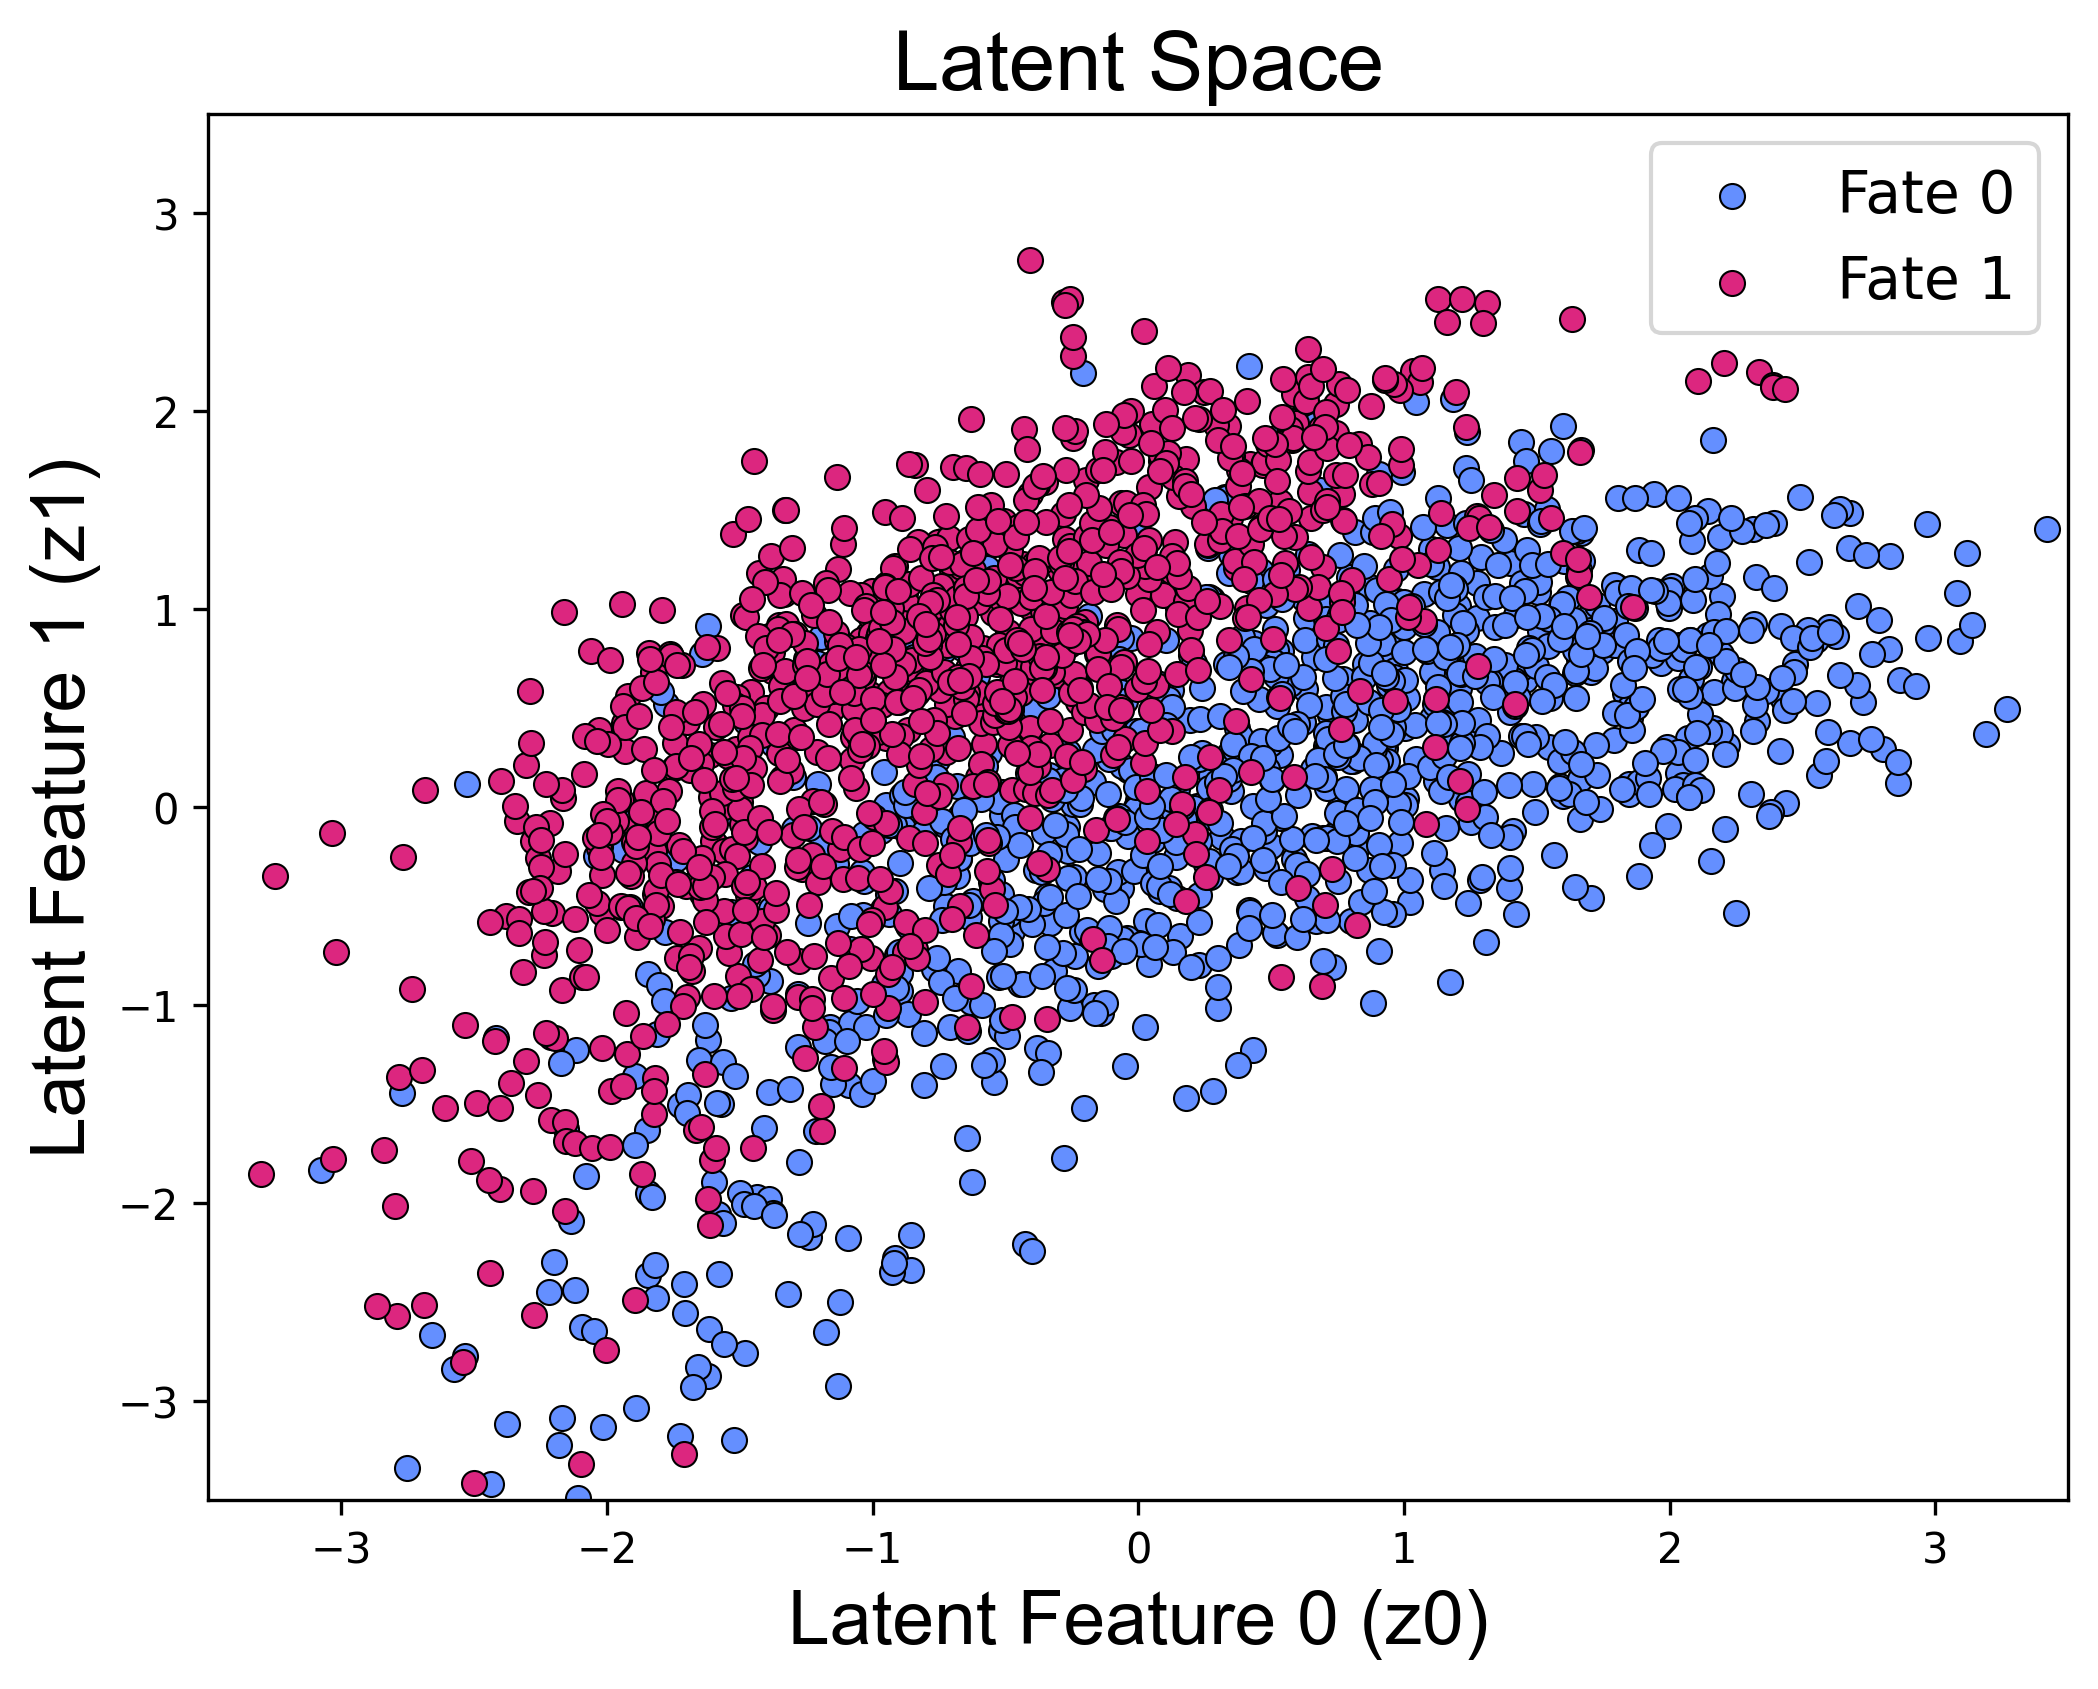

In [10]:
#### latent space correctly saved

x_train = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/images/train_images_augmented.npy')[:,5,:,:]
y_train = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/labels/train_labels_augmented.npy')
x_test = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/images/test_images.npy')[:,5,:,:]
y_test = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/labels/test_labels.npy')

encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
discriminator = Discriminator(latent_dim=config['latent_dim']).model

encoder.load_weights("/Users/inescunha/Downloads/encodertp5.weights.h5")
decoder.load_weights("/Users/inescunha/Downloads/decodertp5.weights.h5")

# Predict the latent representations
latent_2d = encoder.predict(x_train)  # Shape (1380, 2)

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately with thin gray edges
plt.scatter(latent_2d[y_train == 0][:, 0], latent_2d[y_train == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_2d[y_train == 1][:, 0], latent_2d[y_train == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Set axis limits
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")

# Legend and grid
plt.legend(fontsize=14)
#plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

#plt.savefig("ls_tp5_rasterised.eps", dpi=600, bbox_inches="tight")
plt.show()


## 100% of cell time

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


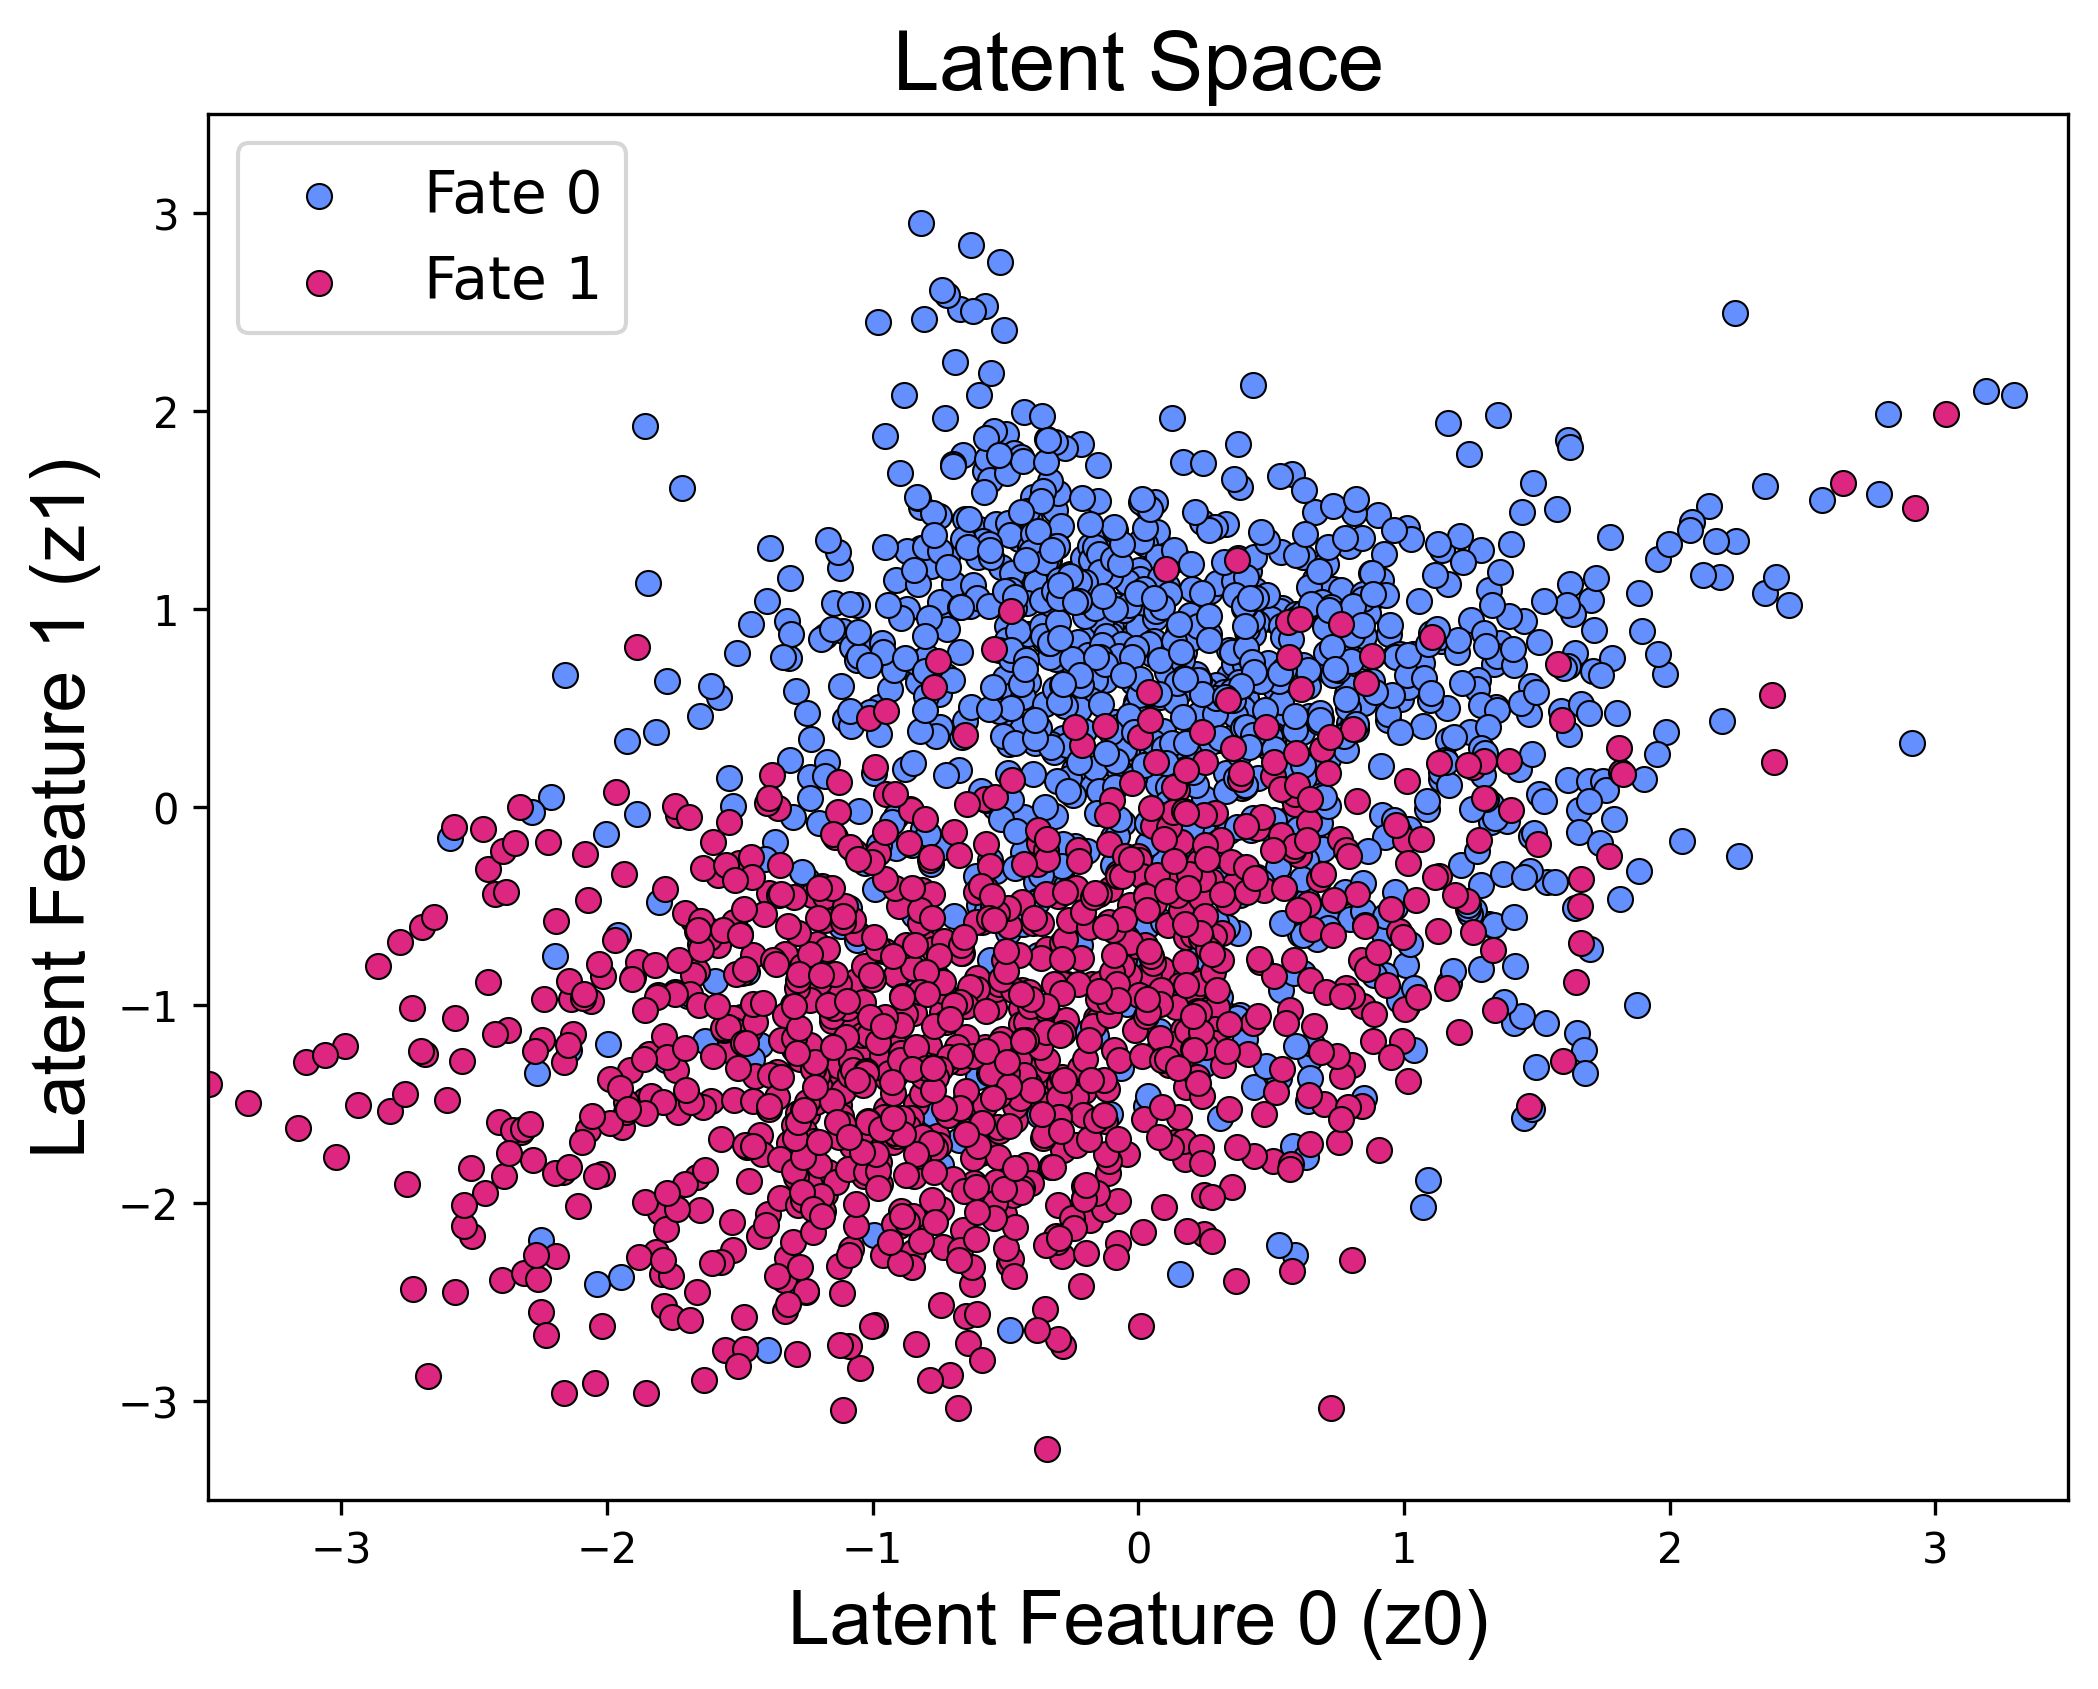

In [11]:
x_train = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/images/train_images_augmented.npy')[:,10,:,:]
y_train = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/labels/train_labels_augmented.npy')
x_test = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/images/test_images.npy')[:,10,:,:]
y_test = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/labels/test_labels.npy')

encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
discriminator = Discriminator(latent_dim=config['latent_dim']).model

encoder.load_weights("/Users/inescunha/Downloads/encodertp10.weights.h5")
decoder.load_weights("/Users/inescunha/Downloads/decodertp10.weights.h5")

# Predict the latent representations
latent_2d = encoder.predict(x_train)  # Shape (1380, 2)

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately with thin gray edges
plt.scatter(latent_2d[y_train == 0][:, 0], latent_2d[y_train == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_2d[y_train == 1][:, 0], latent_2d[y_train == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Set axis limits
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")

# Legend and grid
plt.legend(fontsize=14)
#plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

#plt.savefig("ls_tp10_rasterised.eps", dpi=600, bbox_inches="tight")
plt.show()
